# Creating a classification model and comparing classifiers and feature extraction techniques

In [3]:
# importing libraries
import os
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from skimage import data, exposure
import numpy as np
import pywt
import pywt.data
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [14]:
# first feature selection technique is HOG
def calculate_hog_features(image):
    hog_image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_AREA)
    fd, hog_image = hog(hog_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

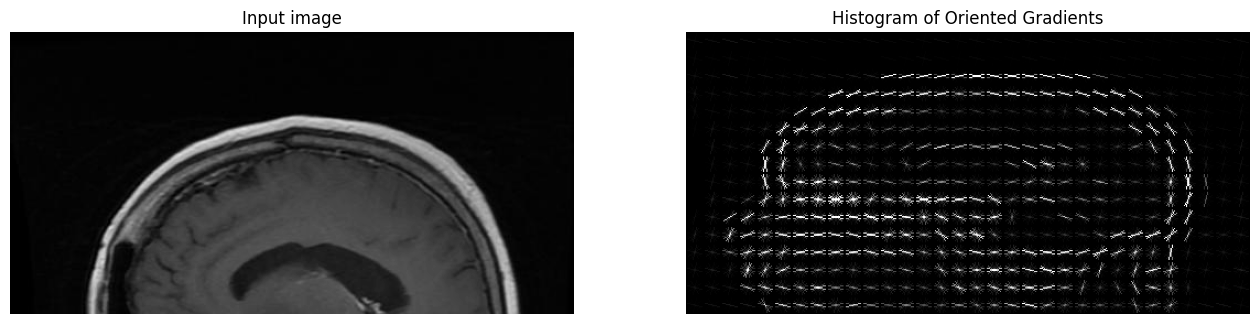

In [15]:
# showing example of what the hog features show

img = cv2.imread('./dataset/image/IMAGE_0000.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fd, hog_image = calculate_hog_features(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [16]:
# second feature is wavelets with 'haar' feature

# adapting function so that I can apply the transform multiple times
def wavelet_feature(original, iterations):
    for i in range(iterations):
        coeffs = pywt.dwt2(original, 'haar')
        LL, (LH, HL, HH) = coeffs
        original = LL
    return coeffs
    

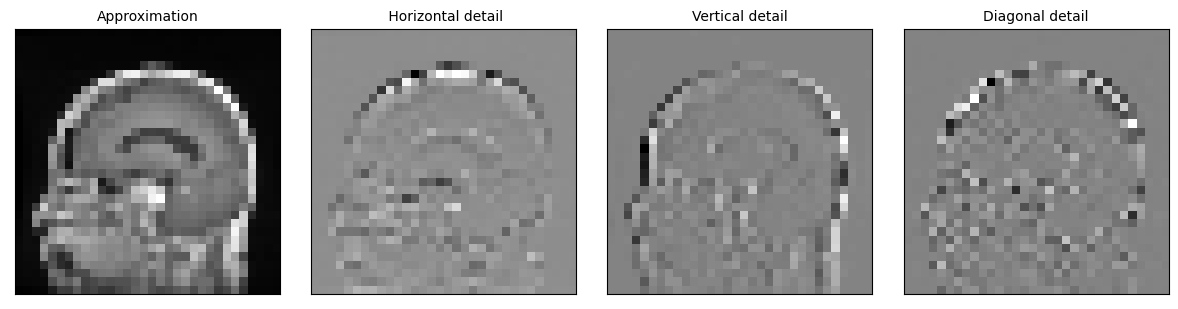

In [17]:
# Load image
original = cv2.imread('./dataset/image/IMAGE_0000.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs = wavelet_feature(original, 4)
LL, (LH, HL, HH) = coeffs
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [18]:
# saving features for comparisons
# creating directories for features to go in
try:
    os.mkdir('./features_task_a')
except:
    print('Directory already created')
try:
    os.mkdir('./features_task_a/train')
except:
    print('Directory already created')
try:
    os.mkdir('./features_task_a/test')
except:
    print('Directory already created')

Directory already created
Directory already created
Directory already created


In [19]:
# turning classes into numbers so that it can be used as a binary classifier
classes = {'meningioma_tumor': 0, 'no_tumor': 1, 'glioma_tumor': 1, 'pituitary_tumor': 1}

# function to extract and save features for future use
def feature_extraction(train_test):
    df = pd.read_csv(f'./dataset/{train_test}.csv')
    hog_features = []
    wavelet_features_2 = []
    wavelet_features_3 = []
    labels = []
    for row in tqdm(df.iterrows()):
        image_name = row[1][0]
        label = row[1][1]
        # opening image
        img = cv2.imread(f'./dataset/{train_test}/{image_name}')
        
        # grayscaling image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # normalising images between 0 and 1
        img = img/255

        # resizing images to 256 pixels square

        img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)


        # creating features and appending to arrays
        features, hog_image = calculate_hog_features(img)
        hog_features.append(features)

        features = wavelet_feature(img, 2)
        LL, (LH, HL, HH) = features
        wavelet_features_2.append(LL.flatten())

        features = wavelet_feature(img, 3)
        LL, (LH, HL, HH) = features
        wavelet_features_3.append(LL.flatten())

        # saving labels
        labels.append(classes[label])

    # saving so that it doesnt need to be run multiple times
    try:
        np.save(f'./features_task_a/{train_test}/hog', hog_features)
    except:
        print("Features already created")
    
    try:
        np.save(f'./features_task_a/{train_test}/wavelet_3x', wavelet_features_3)
    except:
        print("Features already created")

    try:
        np.save(f'./features_task_a/{train_test}/labels', labels)
    except:
        print("Features already created")

    try:
        np.save(f'./features_task_a/{train_test}/wavelet_2x', wavelet_features_2)
    except:
        print("Features already created")

In [20]:
# running feaeture extraction
feature_extraction('train')
feature_extraction('test')

2750it [02:33, 17.94it/s]
900it [00:50, 17.98it/s]


# Training and Evaluating SVM RBF Classifier

In [12]:
# creating model and evaluating
# features will be an array of features which will be concatenated together from different feature extraction methods
def classifier(features_selected):
    x_train = []
    x_test = []
    for feature_type in features_selected:
        # loading features
        x_train.append(np.load(f'./features_task_a/train/{feature_type}.npy'))
        x_test.append(np.load(f'./features_task_a/test/{feature_type}.npy'))
    x_train = tuple(x_train)
    x_test = tuple(x_test)
    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    y_train = np.load(f'./features_task_a/train/labels.npy')
    y_test = np.load(f'./features_task_a/test/labels.npy')
    # SVM model

    scalar = StandardScaler()
    pca = PCA()
    svc = svm.SVC()

    pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("svc", svc)])
    # parameters = [
    #     {
    #         'svc__kernel':['rbf'], 
    #         'svc__C':[0.1, 1, 10, 100], 
    #         'svc__gamma':[1, 0.1, 0.01, 0.001, 0.0001], 
    #         'pca__n_components': [10, 50, 100, 200]
    #     }, 
    #     {
    #         'svc__kernel':['poly'], 
    #         'svc__C':[0.1, 1, 10, 100], 
    #         'svc__gamma':[1, 0.1, 0.01, 0.001, 0.0001], 
    #         'pca__n_components': [10, 50, 100, 200], 
    #         'svc__degree': [1, 2, 3, 4, 5]
    #     }
    # ]

    parameters = {
            'svc__kernel':['rbf'], 
            'svc__C':[10], 
            'svc__gamma':[0.01, 0.001, 0.0001], 
            'pca__n_components': [0.9, 0.95, 0.99, 50, 100]
        }
    grid = GridSearchCV(pipe, parameters, refit='accuracy',  verbose = 3, n_jobs=1, scoring=['f1', 'accuracy'])

    # grid = HalvingGridSearchCV(pipe, parameters, verbose=3)
    grid.fit(x_train, y_train)


    # # ada boost model
    # scalar = StandardScaler()
    # pca = PCA()
    # clf = AdaBoostClassifier()

    # pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("adaboost", clf)])

    # parameters = {
    #     'pca__n_components': [10, 50, 100, 200],
    #     'adaboost__n_estimators': [200, 300, 400]
    # }

    # grid = GridSearchCV(pipe, parameters, refit=True, verbose = 3)
    # grid.fit(x_train, y_train)
    

    return grid, x_test, y_test

In [13]:
import pickle

parameters = ['hog', 'wavelet_3x', 'wavelet_2x']
grid, x_test, y_test = classifier(parameters)


filename = f"./models/{'halfvalidate'.join(parameters)}.sav"
pickle.dump(grid, open(filename, 'wb'))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END pca__n_components=0.9, svc__C=10, svc__gamma=0.01, svc__kernel=rbf; accuracy: (test=0.807) f1: (test=0.890) total time=  14.4s
[CV 2/5] END pca__n_components=0.9, svc__C=10, svc__gamma=0.01, svc__kernel=rbf; accuracy: (test=0.807) f1: (test=0.890) total time=  14.4s
[CV 3/5] END pca__n_components=0.9, svc__C=10, svc__gamma=0.01, svc__kernel=rbf; accuracy: (test=0.807) f1: (test=0.890) total time=  14.2s
[CV 4/5] END pca__n_components=0.9, svc__C=10, svc__gamma=0.01, svc__kernel=rbf; accuracy: (test=0.804) f1: (test=0.888) total time=  14.3s
[CV 5/5] END pca__n_components=0.9, svc__C=10, svc__gamma=0.01, svc__kernel=rbf; accuracy: (test=0.807) f1: (test=0.890) total time=  14.4s
[CV 1/5] END pca__n_components=0.9, svc__C=10, svc__gamma=0.001, svc__kernel=rbf; accuracy: (test=0.876) f1: (test=0.926) total time=  14.3s
[CV 2/5] END pca__n_components=0.9, svc__C=10, svc__gamma=0.001, svc__kernel=rbf; accuracy: (test=

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'pca__n_components': 0.99, 'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('svc', SVC(C=10, gamma=0.0001))])


C:\Users\Gebruiker\.conda\envs\AMLS-assigment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


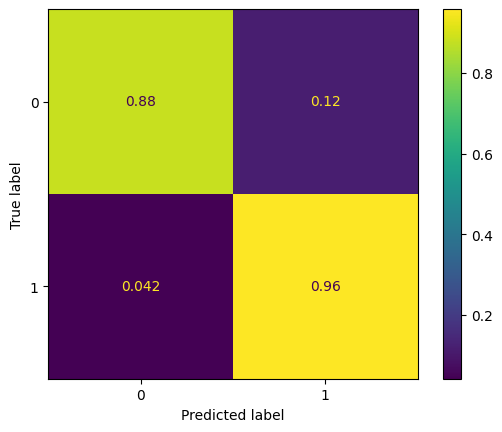

accuracy:  0.9355555555555556
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       258
           1       0.95      0.96      0.95       642

    accuracy                           0.94       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.94      0.94      0.94       900



In [ ]:
plot_confusion_matrix(grid, x_test, y_test, normalize='true')
plt.show()

pred = grid.predict(x_test)
score = accuracy_score(y_test, pred)
print('accuracy: ', score)

# print classification report
print(classification_report(y_test, pred))

# Evaluating Random forest algorithm

In [16]:
# creating model and evaluating
# features will be an array of features which will be concatenated together from different feature extraction methods
def random_forrest_classifier(features_selected):
    x_train = []
    x_test = []
    for feature_type in features_selected:
        # loading features
        x_train.append(np.load(f'./features_task_a/train/{feature_type}.npy'))
        x_test.append(np.load(f'./features_task_a/test/{feature_type}.npy'))
    x_train = tuple(x_train)
    x_test = tuple(x_test)
    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    y_train = np.load(f'./features_task_a/train/labels.npy')
    y_test = np.load(f'./features_task_a/test/labels.npy')
    # SVM model

    scalar = StandardScaler()
    pca = PCA()
    clf = RandomForestClassifier()

    pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("clf", clf)])

    parameters = {
            'clf__n_estimators': [10, 50, 100, 200],
            'clf__bootstrap': [True],
            'pca__n_components': [50, 100, 150]
        }
    grid = GridSearchCV(pipe, parameters, refit='accuracy',  verbose = 3, n_jobs=1, scoring=['f1', 'accuracy'])

    # grid = HalvingGridSearchCV(pipe, parameters, verbose=3)
    grid.fit(x_train, y_train)
    

    return grid, x_test, y_test

In [17]:
import pickle

parameters = ['hog', 'wavelet_3x', 'wavelet_2x']
forest_model, x_test, y_test = random_forrest_classifier(parameters)


filename = f"./models/{'RandomForest'.join(parameters)}.sav"
pickle.dump(forest_model, open(filename, 'wb'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END clf__bootstrap=True, clf__n_estimators=10, pca__n_components=50; accuracy: (test=0.876) f1: (test=0.923) total time=   0.7s
[CV 2/5] END clf__bootstrap=True, clf__n_estimators=10, pca__n_components=50; accuracy: (test=0.875) f1: (test=0.922) total time=   0.7s
[CV 3/5] END clf__bootstrap=True, clf__n_estimators=10, pca__n_components=50; accuracy: (test=0.880) f1: (test=0.923) total time=   0.7s
[CV 4/5] END clf__bootstrap=True, clf__n_estimators=10, pca__n_components=50; accuracy: (test=0.895) f1: (test=0.935) total time=   0.7s
[CV 5/5] END clf__bootstrap=True, clf__n_estimators=10, pca__n_components=50; accuracy: (test=0.898) f1: (test=0.937) total time=   0.8s
[CV 1/5] END clf__bootstrap=True, clf__n_estimators=10, pca__n_components=100; accuracy: (test=0.871) f1: (test=0.919) total time=   1.2s
[CV 2/5] END clf__bootstrap=True, clf__n_estimators=10, pca__n_components=100; accuracy: (test=0.873) f1: (test=0.92

In [18]:
# print best parameter after tuning
print(forest_model.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(forest_model.best_estimator_)

{'clf__bootstrap': True, 'clf__n_estimators': 100, 'pca__n_components': 50}
Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=50)),
                ('clf', RandomForestClassifier())])


C:\Users\Gebruiker\.conda\envs\AMLS-assigment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


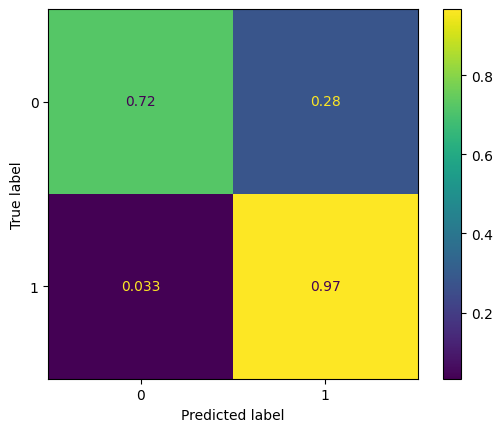

accuracy:  0.8966666666666666
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       258
           1       0.90      0.97      0.93       642

    accuracy                           0.90       900
   macro avg       0.90      0.84      0.87       900
weighted avg       0.90      0.90      0.89       900



In [19]:
plot_confusion_matrix(forest_model, x_test, y_test, normalize='true')
plt.show()

pred = forest_model.predict(x_test)
score = accuracy_score(y_test, pred)
print('accuracy: ', score)

# print classification report
print(classification_report(y_test, pred))

# Training and evaluating KNN classifier

In [4]:
# creating model and evaluating
# features will be an array of features which will be concatenated together from different feature extraction methods
def random_KNN_classifier(features_selected):
    x_train = []
    x_test = []
    for feature_type in features_selected:
        # loading features
        x_train.append(np.load(f'./features_task_a/train/{feature_type}.npy'))
        x_test.append(np.load(f'./features_task_a/test/{feature_type}.npy'))
    x_train = tuple(x_train)
    x_test = tuple(x_test)
    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    y_train = np.load(f'./features_task_a/train/labels.npy')
    y_test = np.load(f'./features_task_a/test/labels.npy')
    # SVM model

    scalar = StandardScaler()
    pca = PCA()
    clf = KNeighborsClassifier()

    pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("clf", clf)])

    parameters = {
            'clf__n_neighbors': [1, 2, 3, 4, 5],
            'pca__n_components': [0.9, 0.95, 0.99]
        }
    grid = GridSearchCV(pipe, parameters, refit='accuracy',  verbose = 3, n_jobs=1, scoring=['f1', 'accuracy'])

    # grid = HalvingGridSearchCV(pipe, parameters, verbose=3)
    grid.fit(x_train, y_train)
    

    return grid, x_test, y_test

In [5]:
import pickle

parameters = ['hog', 'wavelet_3x', 'wavelet_2x']
KNN_model, x_test, y_test = random_KNN_classifier(parameters)


filename = f"./models/{'KNN'.join(parameters)}.sav"
pickle.dump(KNN_model, open(filename, 'wb'))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END clf__n_neighbors=1, pca__n_components=0.9; accuracy: (test=0.933) f1: (test=0.957) total time=  15.0s
[CV 2/5] END clf__n_neighbors=1, pca__n_components=0.9; accuracy: (test=0.913) f1: (test=0.944) total time=  14.5s
[CV 3/5] END clf__n_neighbors=1, pca__n_components=0.9; accuracy: (test=0.940) f1: (test=0.962) total time=  14.5s
[CV 4/5] END clf__n_neighbors=1, pca__n_components=0.9; accuracy: (test=0.927) f1: (test=0.954) total time=  14.5s
[CV 5/5] END clf__n_neighbors=1, pca__n_components=0.9; accuracy: (test=0.938) f1: (test=0.961) total time=  14.5s
[CV 1/5] END clf__n_neighbors=1, pca__n_components=0.95; accuracy: (test=0.936) f1: (test=0.960) total time=  14.5s
[CV 2/5] END clf__n_neighbors=1, pca__n_components=0.95; accuracy: (test=0.913) f1: (test=0.944) total time=  14.9s
[CV 3/5] END clf__n_neighbors=1, pca__n_components=0.95; accuracy: (test=0.947) f1: (test=0.967) total time=  14.5s
[CV 4/5] END clf

In [6]:
# print best parameter after tuning
print(KNN_model.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(KNN_model.best_estimator_)

{'clf__n_neighbors': 1, 'pca__n_components': 0.99}
Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('clf', KNeighborsClassifier(n_neighbors=1))])


C:\Users\Gebruiker\.conda\envs\AMLS-assigment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


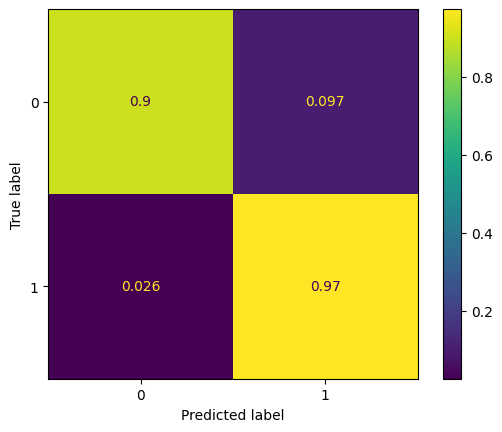

accuracy:  0.9533333333333334
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       258
           1       0.96      0.97      0.97       642

    accuracy                           0.95       900
   macro avg       0.95      0.94      0.94       900
weighted avg       0.95      0.95      0.95       900



In [7]:
plot_confusion_matrix(KNN_model, x_test, y_test, normalize='true')
plt.show()

pred = KNN_model.predict(x_test)
score = accuracy_score(y_test, pred)
print('accuracy: ', score)

# print classification report
print(classification_report(y_test, pred))